<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#**-zeby-nadążyć" data-toc-modified-id="**-zeby-nadążyć-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><strong>**</strong> zeby nadążyć</a></span></li><li><span><a href="#***" data-toc-modified-id="***-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><strong><strong>***</strong></strong></a></span></li></ul></div>

In [3]:
import numpy as np
import pandas as pd
import  statsmodels
from statsmodels.tsa.stattools import coint

np.random.seed(107)
import matplotlib.pyplot as plt

# generate daily returns
Xreturns = np.random.normal(0,1,100)
# sum them and shift all prices up
X = pd.Series(np.cumsum(Xreturns), name='X') + 50

In [4]:
X

0     50.493992
1     49.840014
2     48.365037
3     48.705423
4     47.761784
        ...    
95    42.904689
96    44.259811
97    43.329354
98    43.438429
99    44.952626
Name: X, Length: 100, dtype: float64

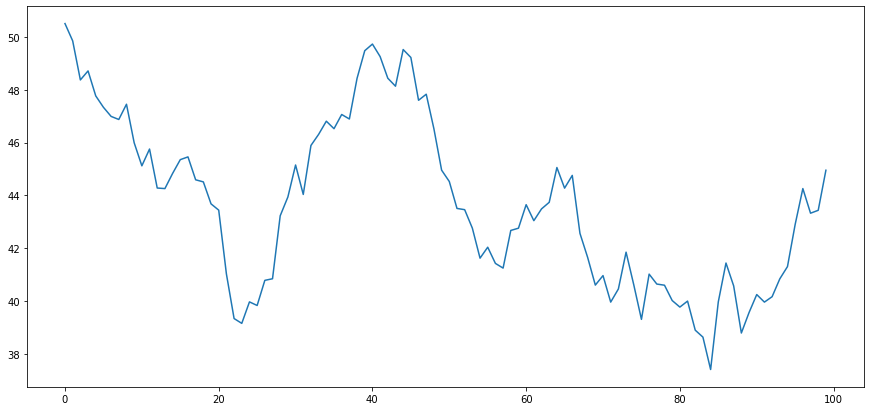

In [2]:
X.plot(figsize = (15,7))
plt.show()

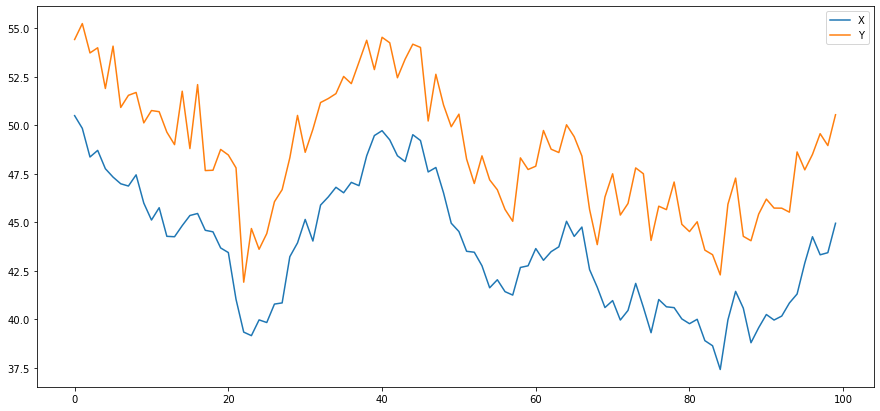

In [6]:
#Y
noise = np.random.normal(0,1,100)
Y = X + 5 + noise
Y.name = 'Y'
pd.concat([X,Y], axis = 1).plot(figsize = (15,7))
plt.show()

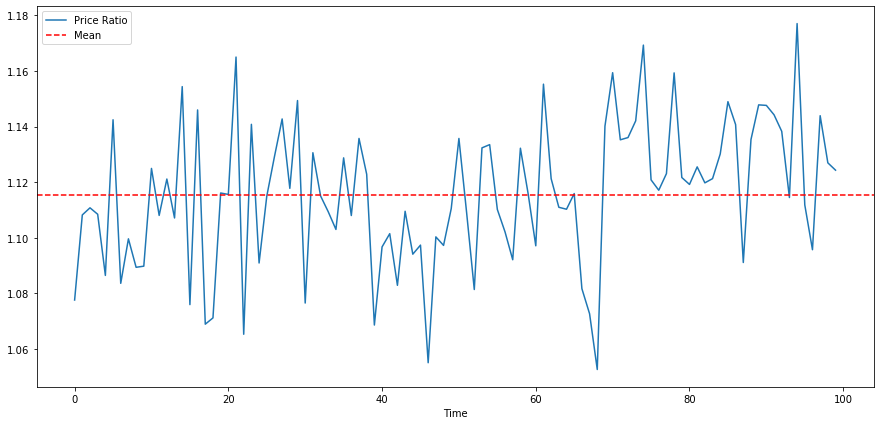

In [18]:
# cointegration
(Y/X).plot(figsize = (15,7))
plt.axhline((Y/X).mean(), color = 'red', linestyle = '--')
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])
plt.show()

In [19]:
score, pvalue, _ = coint(X,Y)
pvalue

2.0503418653415917e-16

In [21]:

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n,n)) # liczba spółek x liczba spółek
    pvalue_matrix = np.ones((n,n))
    keys = data.keys()
    pairs = []

    for i in range(n): #czyli dla każdej spółki
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1,S2)
            score = result[0]
            pvalue = result[1]

            score_matrix[i,j] = score
            pvalue_matrix[i,j] = pvalue

            if pvalue < .05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs



In [23]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2007/12/01'
endDateStr = '2017/12/01'

cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY', 'AAPL', 'ADBE','EBAY','MSFT','QCOM','HPQ','JNPR','AMD','IBM']

ds = YahooStockDataSource(cachedFolderName = cachedFolderName,
    dataSetId = dataSetId,
    instrumentIds = instrumentIds,
    startDateStr = startDateStr,
    endDateStr = endDateStr,
    event = 'history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: SPY
Processing data for stock: AAPL
Processing data for stock: ADBE
Processing data for stock: EBAY
Processing data for stock: MSFT
Processing data for stock: QCOM
Processing data for stock: HPQ
Processing data for stock: JNPR
Processing data for stock: AMD
Processing data for stock: IBM
20% done...
40% done...
60% done...
80% done...


In [24]:
data.head()

,SPY,AAPL,ADBE,EBAY,MSFT,QCOM,HPQ,JNPR,AMD,IBM
2007-11-30,113.433182,5.614009,42.139999,13.704943,25.106365,29.339491,17.108200,25.691572,9.76,70.521133
2007-12-03,112.685326,5.510492,42.689999,13.467875,24.598259,28.749527,16.867434,26.253471,9.66,70.956963
2007-12-04,111.678154,5.539760,43.320000,13.459701,24.486181,28.317844,16.957718,26.288050,9.25,71.493340
2007-12-05,113.547615,5.715061,43.900002,13.631371,25.517334,29.148191,17.275410,27.057411,8.91,72.519173
2007-12-06,115.172867,5.852162,44.540001,13.803040,25.816221,29.177065,17.459330,27.014187,9.07,73.551735


In [25]:
data.keys()

Index(['SPY', 'AAPL', 'ADBE', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD',
       'IBM'],
      dtype='object')

In [26]:
type(data)

pandas.core.frame.DataFrame

In [32]:
coint(data['AAPL'], data['IBM'])

(0.05922836178603789,
 0.9871854025969719,
 array([-3.90079473, -3.33855764, -3.04613478]))

w ten sposób tworzy matrycę z scores, pvalues dla wszystkich kombinacji spółek

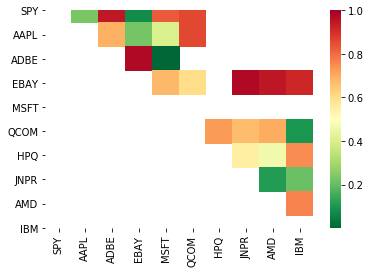

[('ADBE', 'MSFT')]


In [34]:
# seek the cointegrated securities
# heatmap
scores, pvalues, pairs = find_cointegrated_pairs(data)

import seaborn
m = [0,.2, .4, .6, .8, 1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds,
    yticklabels = instrumentIds, cmap = 'RdYlGn_r',
    mask = (pvalues >=.98))
plt.show()
print(pairs)

0.0018311554235898111


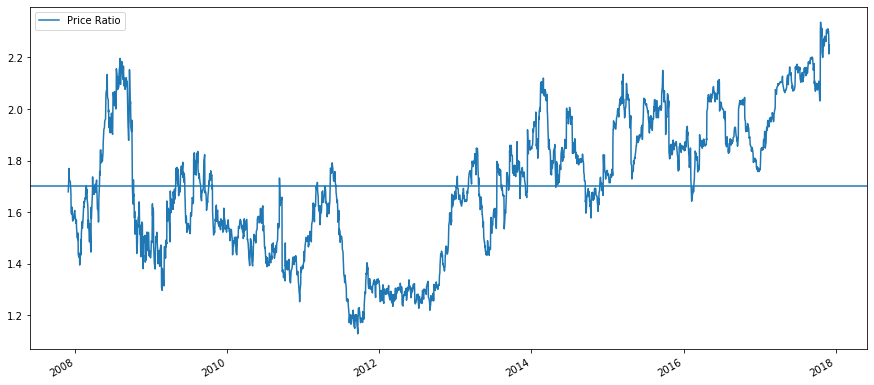

In [37]:
# Look at the prices
S1 = data['ADBE']
S2 = data['MSFT']
score,pvalue,_ = coint(S1,S2)
print(pvalue)

ratios = S1/S2
ratios.plot(figsize = (15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [42]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

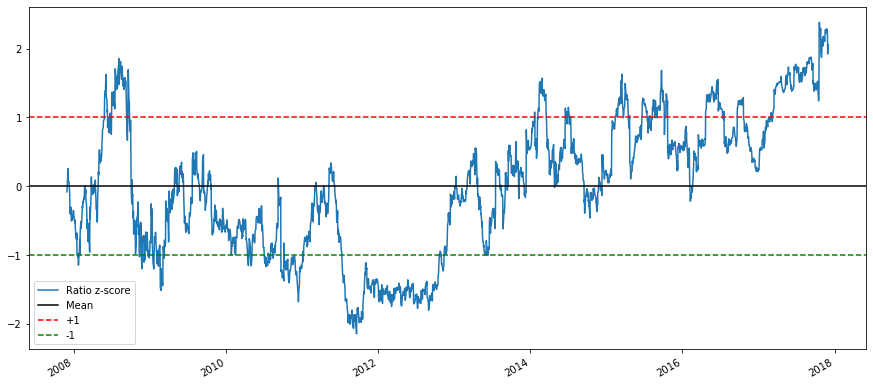

In [43]:
# zscore(ratios).plot(figsize = (15,7))
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color = 'black')
plt.axhline(1., color='red', linestyle='--')
plt.axhline(-1., color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

use 5d MA instead of ratio

In [44]:
# break the data into trainig/test set (7/3 years)

ratios = data['ADBE'] / data['MSFT']
print(len(ratios))
train = ratios[:1762]
test = ratios [1762:]

2519


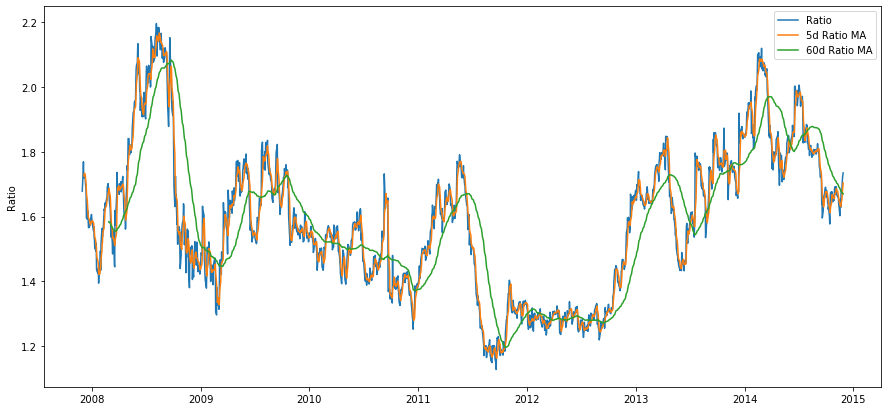

In [48]:
ratios_mavg5 = train.rolling(window = 5, center = False).mean()
ratios_mavg60 = train.rolling(window = 60, center = False).mean()
std_60 = train.rolling(window = 60, center = False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(["Ratio", '5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

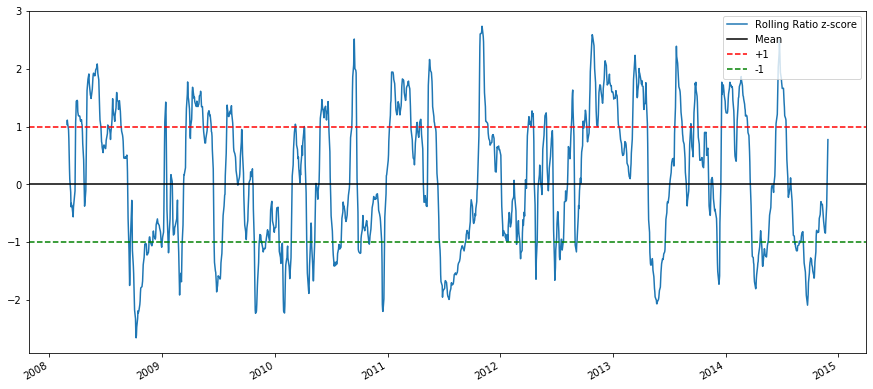

In [53]:
plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color = 'black')
plt.axhline(1, color = 'red', linestyle='--')
plt.axhline(-1, color = 'green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1', '-1'])
plt.show()


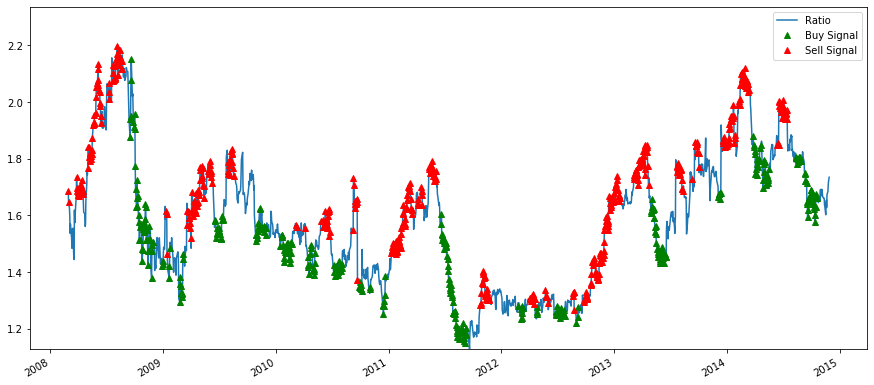

In [60]:
# buy and sell signals from z-score
plt.figure(figsize=(15,7))
train[60:].plot()

buy = train.copy()
sell = train.copy()

buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0

# buy[60:].plot(color = 'g', linestyle = None, marker = '^')
# sell[60:].plot(color = 'r', linestyle = None, marker = '^')
buy[60:].plot(color = 'g', linestyle = 'None', marker = '^')
sell[60:].plot(color = 'r', linestyle = 'None', marker = '^')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(), ratios.max()))

plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

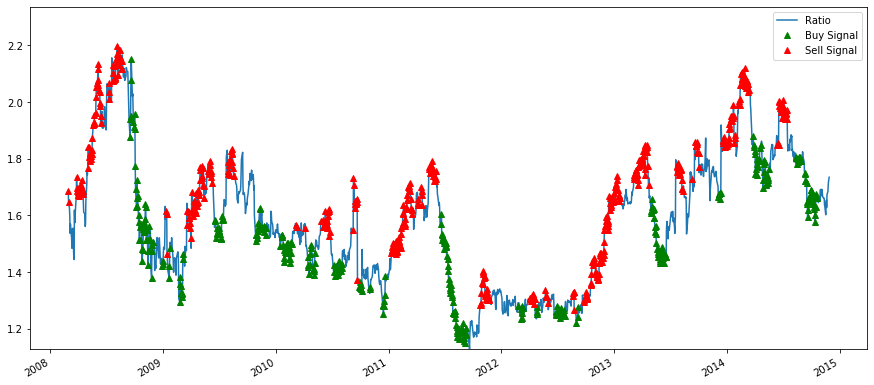

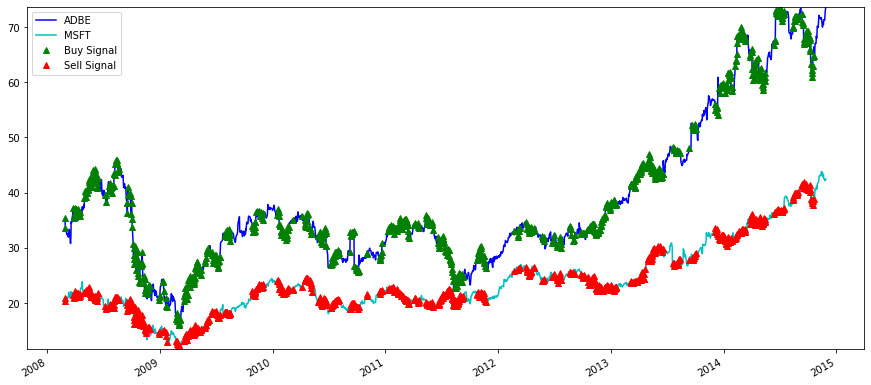

In [85]:
# meaning:
plt.figure(figsize=(15,7))
S1 = data['ADBE'].iloc[:1762]
S2 = data['MSFT'].iloc[:1762]

S1[60:].plot(color = 'b')
S2[60:].plot(color = 'c')
buyR = 0 * S1.copy()
sellR = 0 * S1.copy()

#buying the ratio: buy S1, sell S2
buyR[buy != 0] = S1[buy!=0]
sellR[buy != 0] = S2[buy!=0]

#selling ratio: sell S1
buyR[sell!=0] = S1[sell!=0]
sellR[sell!=0] = S2[sell!=0]

buyR[60:].plot(color = 'g', linestyle = 'None', marker = '^')
sellR[60:].plot(color = 'r', linestyle = 'None', marker = '^')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(), S2.min()), max(S1.max(), S2.max())))

plt.legend(['ADBE', "MSFT", 'Buy Signal', 'Sell Signal'])
plt.show()

In [131]:
#backtest
def trade(S1,S2, window1, window2):
    if window1 == 0 or window2 == 0:
        return 0

    # rolling mean and std:
    ratios = S1/S2
    ma1 = ratios.rolling(window = window1, center=False).mean()
    ma2 = ratios.rolling(window = window2, center=False).mean()

    std = ratios.rolling(window = window2, center = False).std()
    zscore = (ma1 - ma2)/std

    # simulate trading:
    money = 0
    countS1 = 0
    countS2 = 0

    for i in range(len(ratios)):
        #sell if zscore >1
        if zscore[i] >1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -=1
            countS2 += ratios[i]

        elif zscore[i] < -1:
            money -=S1[i] -S2[i] * ratios[i]
            countS1 +=1
            countS2 -= ratios[i]

        #clear positions if -.5 < zscore < .5
        elif abs(zscore[i]) < .5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('z-score:', zscore[i], countS1, countS2, S1[i], S2[i])
    return money

trade(data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762], 5,60 )

631.8345403926969

In [91]:
S1,S2 = data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762]
ratios = S1/S2

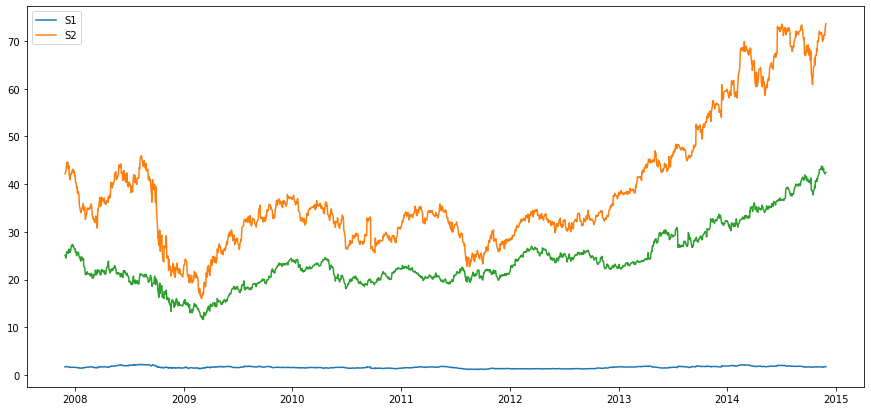

In [127]:
plt.figure(figsize=(15,7))
plt.plot(ratios)
plt.plot(S1)
plt.plot(S2)
plt.legend(['S1', 'S2'])

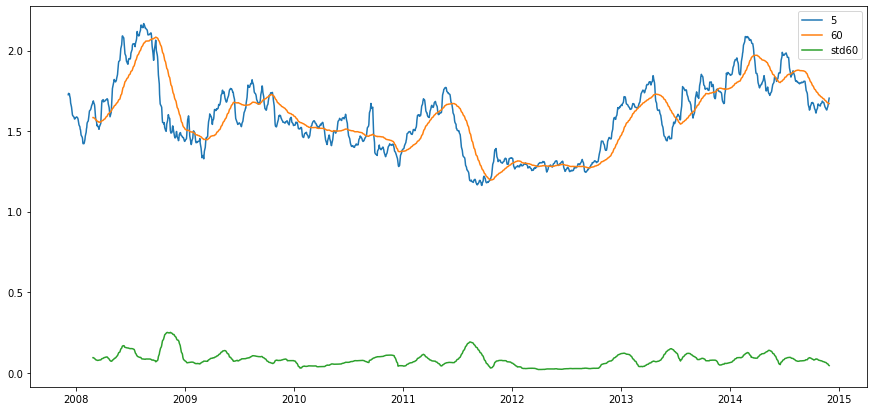

In [124]:
plt.figure(figsize=(15,7))
plt.plot(ratios.rolling(5).mean())
plt.plot(ratios.rolling(60).mean())
plt.plot(ratios.rolling(60).std())
plt.legend(['5', '60', 'std60', 'z-score'])

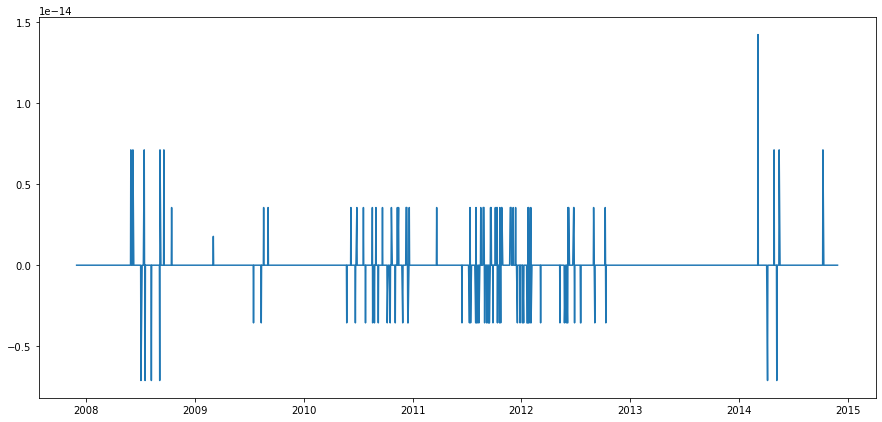

In [126]:
plt.figure(figsize = (15,7))
plt.plot(S1-S2*ratios)

In [133]:
trade(data['ADBE'].iloc[1762:], data['MSFT'].iloc[1762:],5,60)

1017.7289301019675

In [136]:
length_scores = [trade(data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762], 5, l) for l in range(255)]

best_length = np.argmax(length_scores)
print('Best Window length: ', best_length)

Best Window length:  246


In [139]:
# for test data:
length_scores2 = [trade(data['ADBE'].iloc[1762:], data['MSFT'].iloc[1762:], 5, l) for l in range(255)]

best_length2 = np.argmax(length_scores2)
print('Best Window length: ', best_length2)

print("\nLet's compare")
print(f'{best_length} day window: {length_scores2[best_length]}')
print(f'{best_length2} day window: {length_scores2[best_length2]}')


Best Window length:  191

Let's compare
246 day window: 987.0096613479159
191 day window: 1572.1945890247873


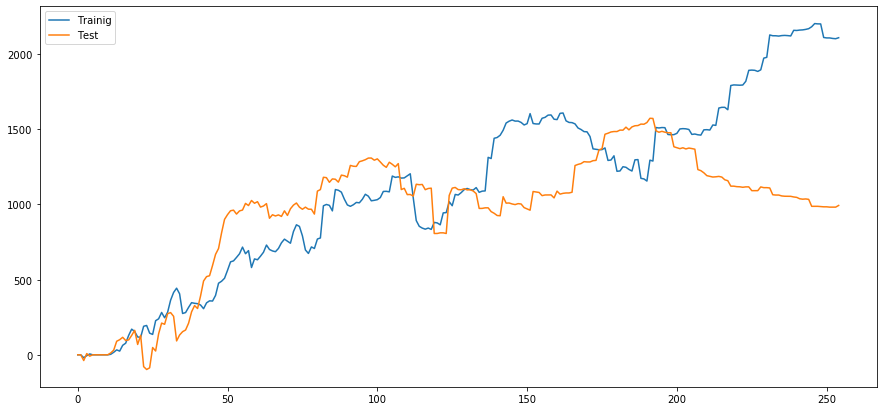

In [144]:
plt.figure(figsize = (15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.legend(['Trainig', 'Test'])